In [3]:
import matplotlib.pyplot as plt
import math
import json
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from utils import num_of_batch_sizes

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def extract_label_value(label, key):
    return int(label.split(key)[1].split(".txt")[0].split("_")[1])

def get_model_info(label, key): 
    model_name = extract_model_name(label)
    with open("models_config.json", "r") as f:
        info = json.load(f)
    
    return info[model_name].get(key, 0)


def extract_nb_layers(label):
    return get_model_info(label, "layers")

def extract_nb_layers_x_graph_size(label):
    return get_model_info(label, "layers") * get_model_info(label, "compiled_graph_size")

def extract_vocab_size(label):
    return get_model_info(label, "vocab_size")

def extract_tokenizer_size(label):
    return get_model_info(label, "tokenizer_size")

def extract_head_size_x_layers(label):
    attn_heads = get_model_info(label, "attn_heads")
    attn_heads_num = get_model_info(label, "attn_heads_num")
    hidden_size = get_model_info(label, "hidden_size")
    num_layers = get_model_info(label, "layers")
    ffn_dim = get_model_info(label, "ffn_dim")
    
    delta = 1
    if attn_heads == 1:
        delta = 1.4
    elif attn_heads != attn_heads_num:
        delta = 1.1
    
    return 5e-8 * num_layers * (hidden_size * attn_heads_num + 0.5 * ffn_dim) * delta

def extract_model_name(label):
    return label.split("model_")[1].split("_")[0].split(".txt")[0]

def extract_cuda_graph_size(label):
    return extract_label_value(label, "cuda-graph-sizes")

def extract_max_seq_len_to_capture(label):
    return extract_label_value(label, "max-seq-len-to-capture")

def extract_batch_size(label):
    return num_of_batch_sizes(extract_cuda_graph_size(label))

def extract_batch_size_x_model_size(label):
    return extract_batch_size(label) * extract_model_size(label)

def extract_model_size(label):
    model_name = extract_model_name(label)
    size = model_name.split("-")[1]
    num = float(size[:-1])
    if "m" in size:
        num /= 1000
    
    return num

def get_sort_indices(labels, sort_by="model_size"):

    if sort_by == "model_size":
        sizes = [extract_model_size(label) for label in labels]
        return sorted(range(len(labels)), key=lambda i: sizes[i])
    elif sort_by == "alphabetical":
        return sorted(range(len(labels)), key=lambda i: natural_sort_key(labels[i]))
    
def get_labels_matrics(json_filepath, sort_by):
    with open(json_filepath, 'r') as f:
        json_data = json.load(f)

    labels = json_data['labels']
    metrics = json_data['data']
    
    # Modify metrics
    
    # Substract torch.compile, graph_compile_cached from kv_cache_profiling
    metrics['kv_cache_profiling'] = [
        metrics['kv_cache_profiling'][i] - metrics['torch.compile'][i] - (metrics['graph_compile_cached'][i] if metrics['graph_compile_cached'][i] is not None else 0)
        for i in range(len(metrics['kv_cache_profiling']))
    ]
    
    # No need for model_loading (it's just a sum of load_weights and model_init)
    del metrics['model_loading']
    
    # No need for torch.compile (it's just a sum of dynamo_transfer_time and graph_compile_general_shape)
    del metrics['torch.compile']
    
    # No need for init_engine (it's just a sum of kv_cache_profiling and graph_capturing)
    del metrics['init_engine']
    
    # No need for kv_cache_init (it's just constant time for all models ~0.01s)
    if 'kv_cache_init' in metrics:
        del metrics['kv_cache_init']
    
    # No need for actual_total_time (it's just same as total_time + 14s platform detection overhead)
    del metrics['actual_total_time']
    
    sort_indices = get_sort_indices(labels, sort_by)
    sorted_labels = [labels[i] for i in sort_indices]
    
    return metrics, sorted_labels, sort_indices

def draw_graph(json_file_path, sort_by):
    
    metrics, sorted_labels, sort_indices = get_labels_matrics(json_file_path, sort_by)

    # Number of metrics (keys in 'data')
    num_metrics = len(metrics)
    cols = 3  # number of columns in the subplot grid
    rows = math.ceil(num_metrics / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()
    
    # Custom naming for batch size
    for i, label in enumerate(sorted_labels):
        if "cuda-graph-sizes" in label:
            cuda_graph_sizes = extract_cuda_graph_size(label)
            num_batches = num_of_batch_sizes(cuda_graph_sizes)
            sorted_labels[i] = label.replace(f"cuda-graph-sizes_{cuda_graph_sizes}", f"batch-size_{num_batches}")

    for idx, (metric_name, values) in enumerate(metrics.items()):
        ax = axes[idx]
        cleaned_values = [v if v is not None else 0 for v in values]
        sorted_values = [cleaned_values[i] for i in sort_indices]
        bars = ax.bar(range(len(sorted_labels)), sorted_values)
        ax.set_title(metric_name)
        ax.set_xticks(range(len(sorted_labels)))
        ax.set_xticklabels(
            [label.replace("output_", "").replace("model_", "").replace(".txt", "") for label in sorted_labels],
            rotation=90,
            fontsize=10
        )
        ax.set_ylabel("Time (s)")
        max_val = max(cleaned_values)
        upper = max_val * 1.15 if max_val > 0 else 1
        ax.set_ylim(0, upper)
        
        # Annotate each bar with its height
        for bar in bars:
            height = bar.get_height()
            if height == 0:
                continue
            offset = 0.05 * max(cleaned_values)  # 5% of max value
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + offset if height > 0 else offset,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=8
            )

    # Increase vertical spacing
    fig.tight_layout(h_pad=2.5)

    plt.show()
    

def draw_multiple_relationships(values_list, sorted_labels_list, titles, xlabel, y_axis_func):
    assert len(values_list) == len(sorted_labels_list) == len(titles), "All input lists must have the same length"

    num_plots = len(values_list)
    cols = 3
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for idx, (values, sorted_labels, title) in enumerate(zip(values_list, sorted_labels_list, titles)):
        ax = axes[idx]

        # Data from the table
        models = [extract_model_name(sorted_labels[i]) for i in range(len(sorted_labels))]
        param_sizes = np.array([y_axis_func(sorted_labels[i]) for i in range(len(sorted_labels))]).reshape(-1, 1)
        times = np.array(values)

        # Linear regression
        reg = LinearRegression().fit(param_sizes, times)
        predicted_times = reg.predict(param_sizes)

        # Plotting
        ax.scatter(param_sizes, times, color='blue', label='Actual Data')
        ax.plot(param_sizes, predicted_times, color='red', linestyle='--', label='Linear Fit')
        for i, label in enumerate(models):
            ax.text(param_sizes[i], times[i] + 0.2, label, ha='center', fontsize=8)

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Time (s)")
        ax.grid(True)
        ax.legend()

    # Hide any unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def draw_relationship(json_filepath, order_by, keys, xlabel, y_axis_func):
    metrics, sorted_labels, sort_indices = get_labels_matrics(json_filepath, order_by)

    values_list = []
    sorted_labels_list = []
    titles = []

    for k in keys:
        values_list.append([metrics[k][sort_indices[i]] for i in range(len(sorted_labels))])
        sorted_labels_list.append(sorted_labels)
        titles.append(f"{k}")

    draw_multiple_relationships(
        values_list=values_list,
        sorted_labels_list=sorted_labels_list,
        titles=titles,
        xlabel=xlabel,
        y_axis_func=y_axis_func
    )
    

def draw_metric_wrt_metric(configs, x_axis):
    num_plots = len(configs)
    cols = 3
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for idx, config in enumerate(configs):
        json_filepath = config['json_filepath']
        metric = config['metric']

        metrics, sorted_labels, sort_indices = get_labels_matrics(json_filepath, "model_size")

        metric_values = [metrics[metric][sort_indices[i]] for i in range(len(sorted_labels))]
        model_names = [extract_model_name(label) for label in sorted_labels]
        model_metric_nb = [get_model_info(label, x_axis["key"]) for label in sorted_labels]

        # Now sort the values and model names based on the number of metric
        sorted_indices = sorted(range(len(model_metric_nb)), key=lambda i: model_metric_nb[i])
        metric_values_sorted = [metric_values[i] for i in sorted_indices]
        model_names_sorted = [model_names[i] for i in sorted_indices]
        model_metric_nb_sorted = [model_metric_nb[i] for i in sorted_indices]

        labels = [f"{model_names_sorted[i]} ({model_metric_nb_sorted[i]})" for i in range(len(model_names_sorted))]

        ax = axes[idx]
        ax.bar(labels, metric_values_sorted)
        ax.set_xlabel("Model Names")
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} vs {x_axis['title']}")
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

    # Hide any unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Model Size

### Graph Compilation Not Cached

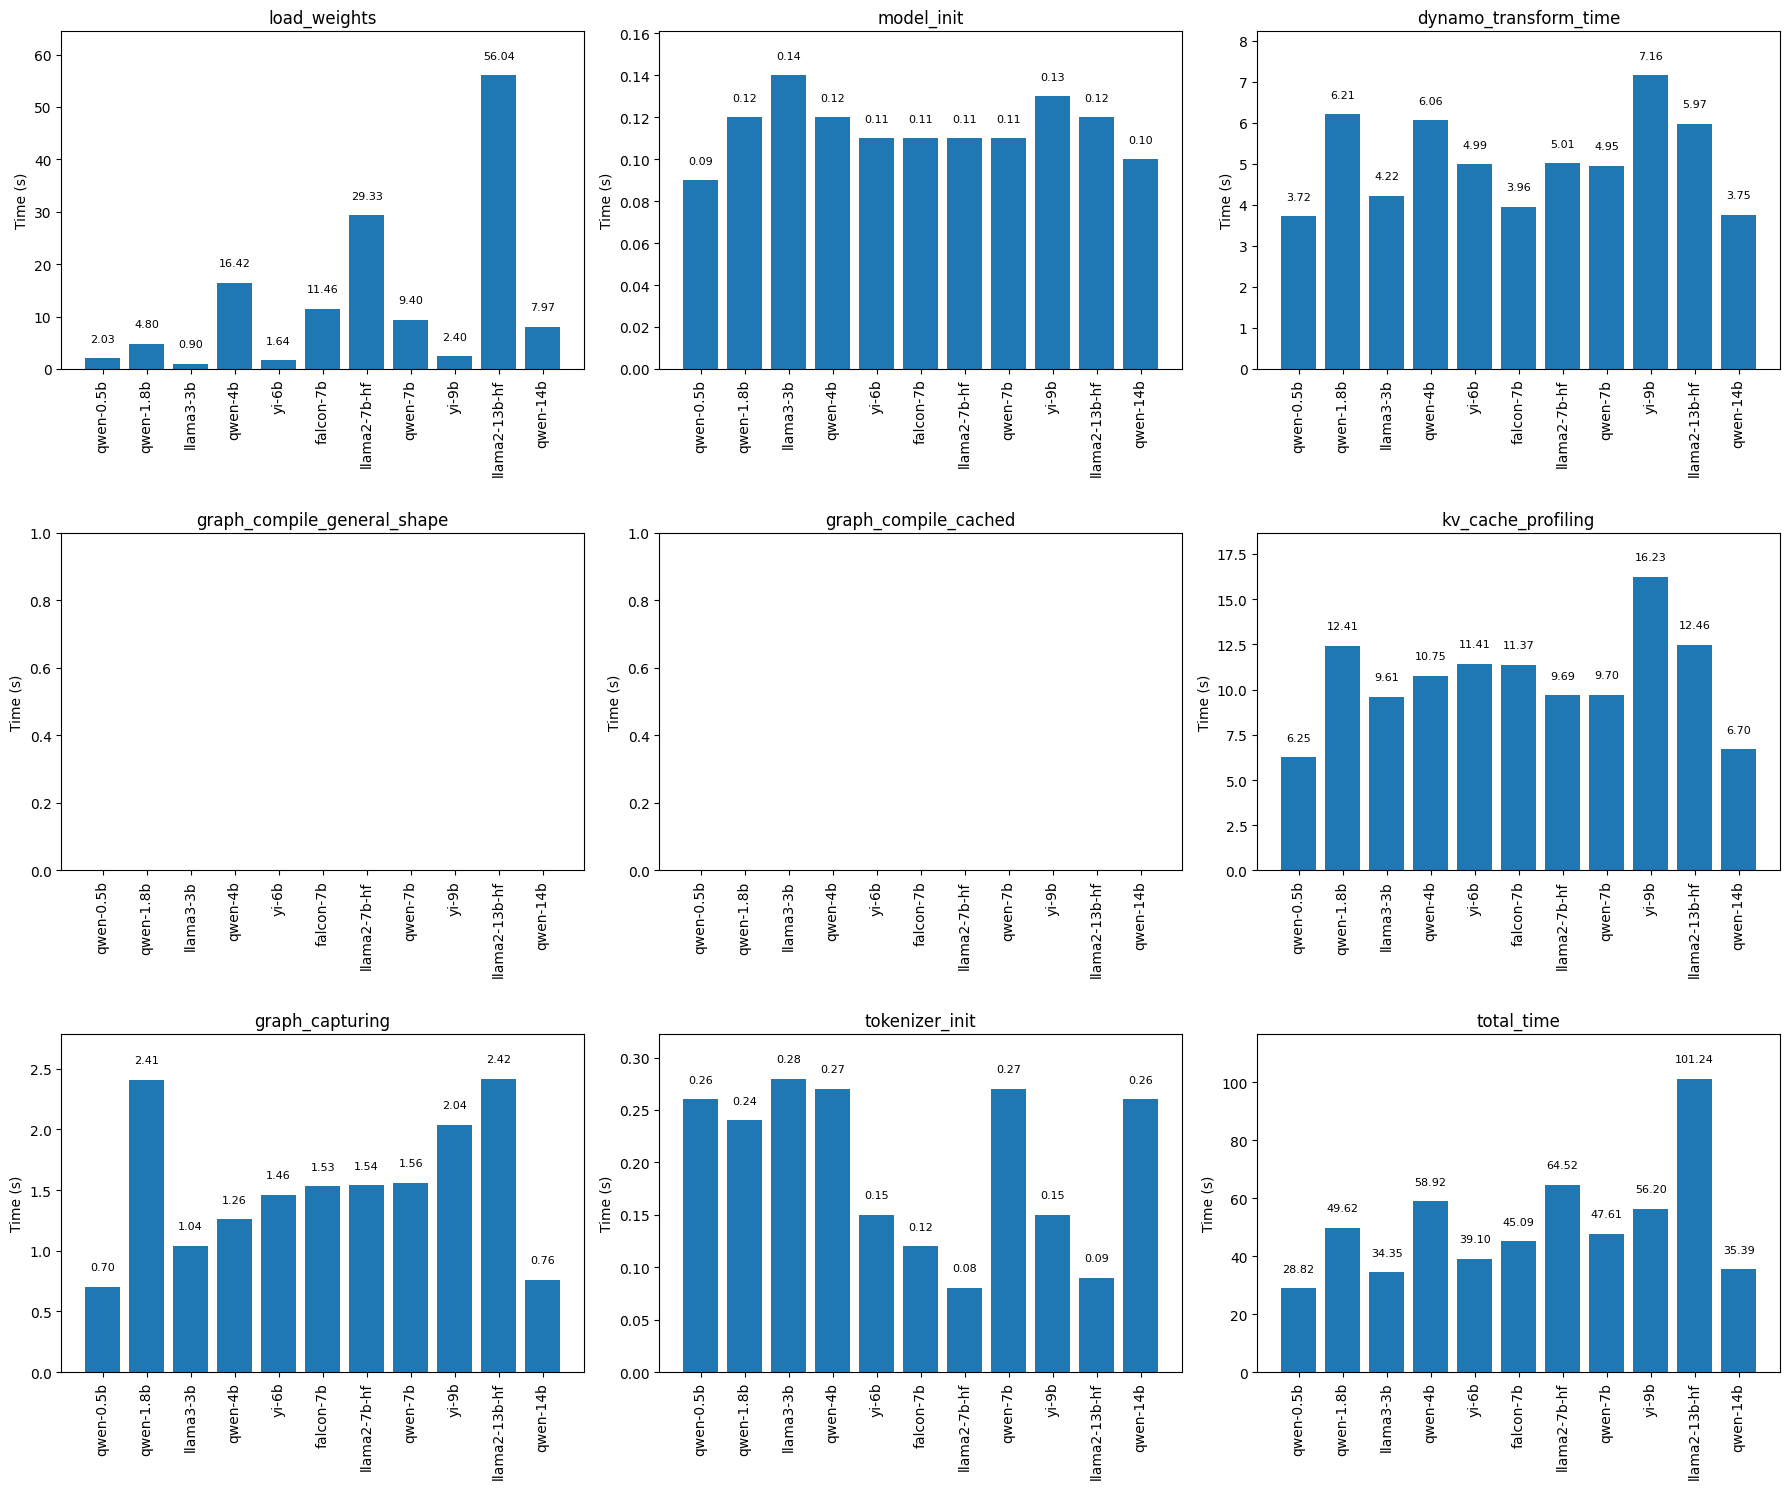

In [25]:
model_size_not_cached_json_filepath = "examples/model_size/uncached/comparison_results.json"
draw_graph(model_size_not_cached_json_filepath, "model_size")

### Graph Compilation Cached

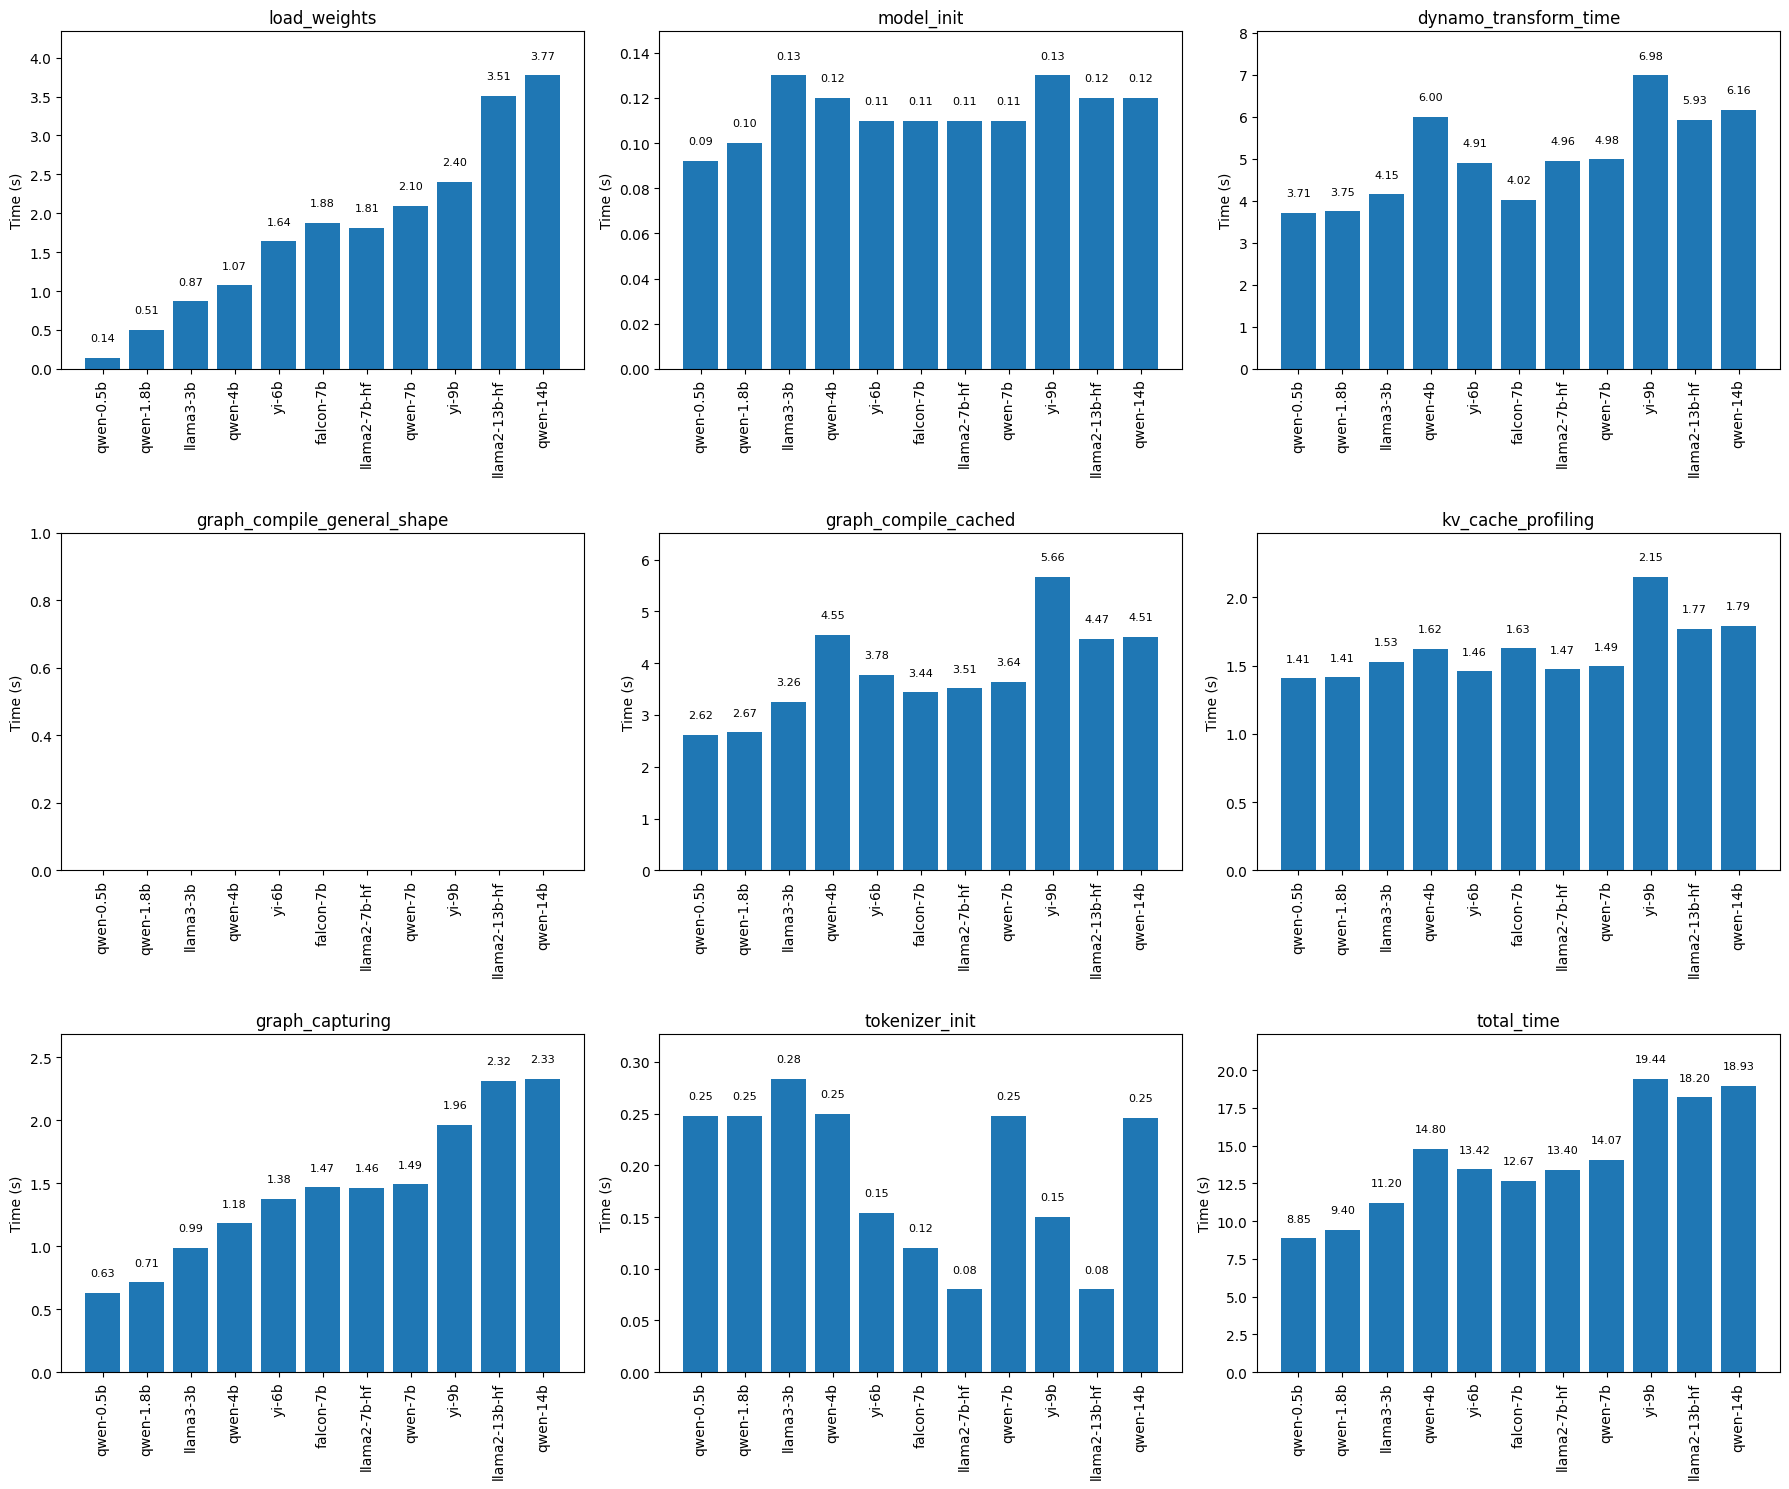

In [22]:
model_size_json_filepath = "examples/model_size/avg_comparison_results.json"
draw_graph(model_size_json_filepath, "model_size")

#### Relation between load_weights, graph_capturing and model size

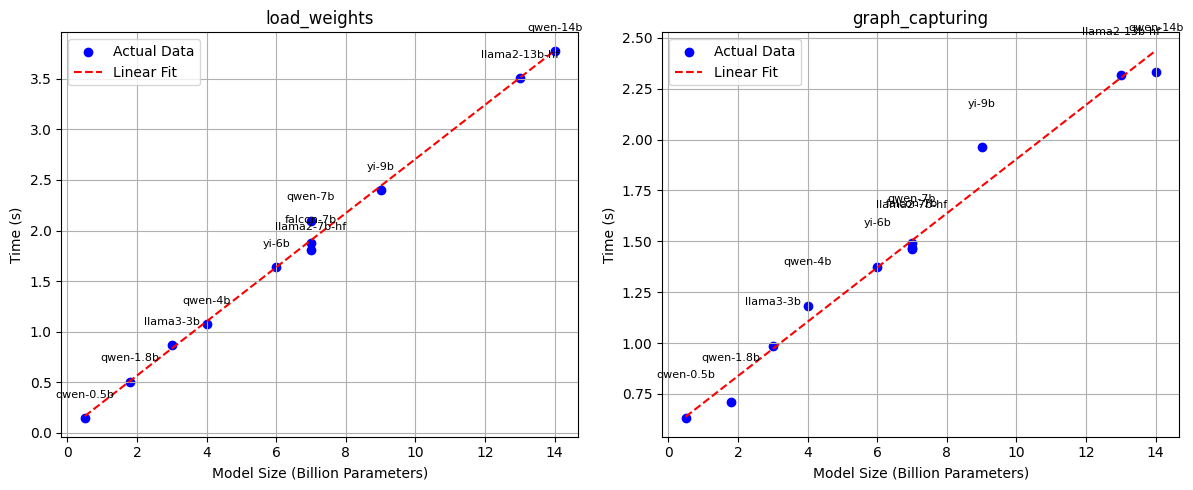

In [23]:
keys = ["load_weights", "graph_capturing"]
draw_relationship(model_size_json_filepath, "model_size", keys, "Model Size (Billion Parameters)", extract_model_size)

#### Relation between graph_compile_cached, dynamo_transform_time and nb_layers

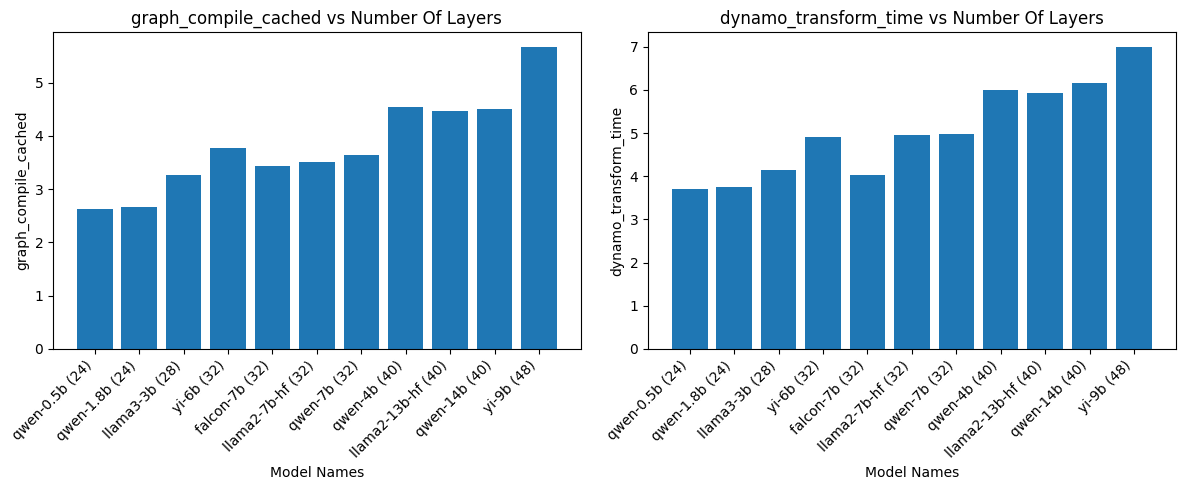

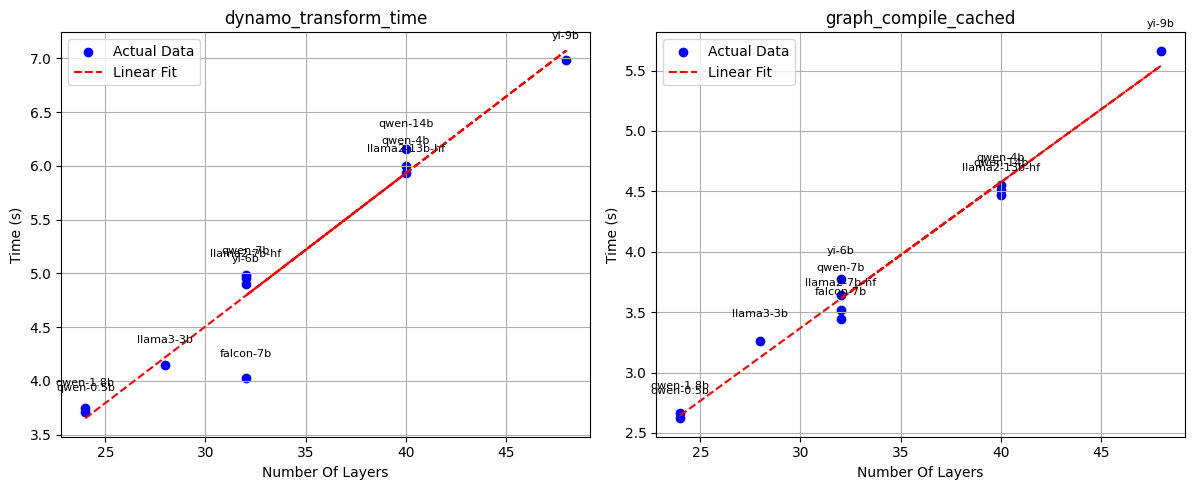

In [28]:
draw_metric_wrt_metric([
    {"json_filepath": model_size_json_filepath, "metric": "graph_compile_cached"},
    {"json_filepath": model_size_json_filepath, "metric": "dynamo_transform_time"},
    # {"json_filepath": model_size_not_cached_json_filepath, "metric": "graph_compile_general_shape"}
], {"key": "layers", "title": "Number Of Layers"})

keys = ["dynamo_transform_time", "graph_compile_cached"]
draw_relationship(model_size_json_filepath, "model_size", keys, "Number Of Layers", extract_nb_layers)

# keys = ["graph_compile_cached"]
# draw_relationship(model_size_json_filepath, "model_size", keys, "Number Of Layers * Graph Size", extract_nb_layers_x_graph_size)

# keys = ["graph_compile_general_shape"]
# draw_relationship(model_size_not_cached_json_filepath, "model_size", keys, "Number Of Layers", extract_nb_layers)

#### Relation between kv_cache_profiling and ??

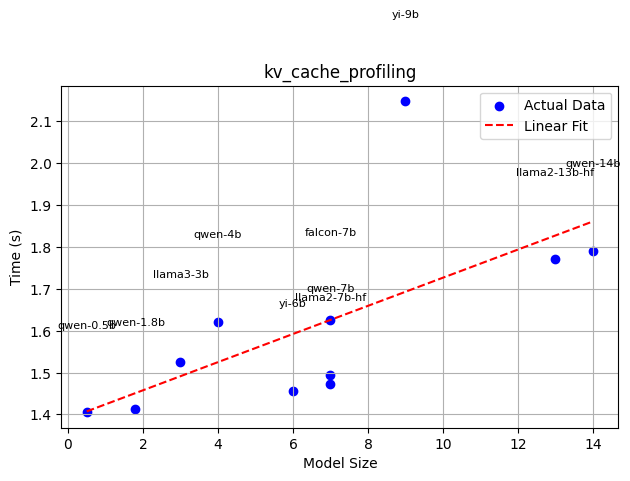

In [29]:
keys = ["kv_cache_profiling"]
draw_relationship(model_size_json_filepath, "model_size", keys, "Model Size", extract_model_size)

#### Relation between tokenizer_init_time and vocab_size

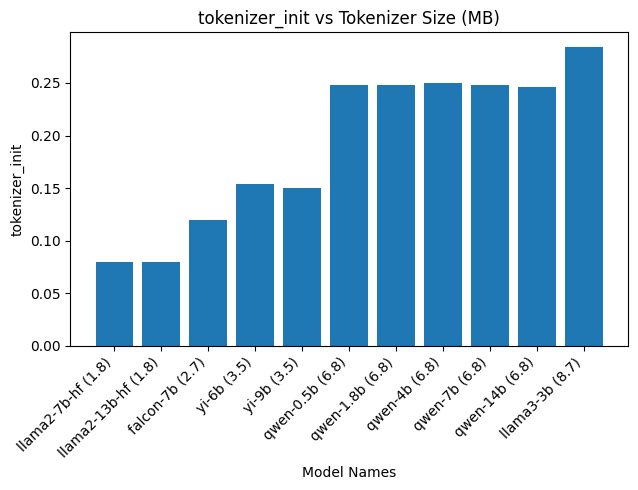

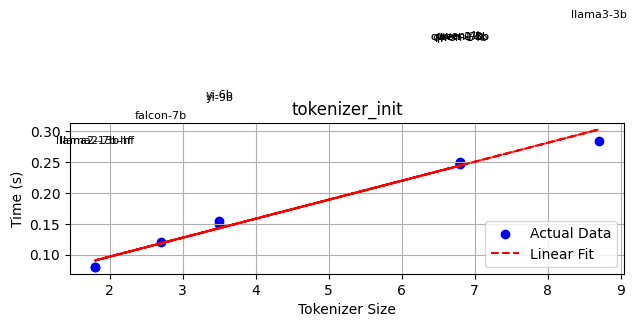

In [30]:
draw_metric_wrt_metric([{"json_filepath": model_size_json_filepath, "metric": "tokenizer_init"}], {"key": "tokenizer_size", "title": "Tokenizer Size (MB)"})
draw_relationship(model_size_json_filepath, "model_size", ["tokenizer_init"], "Tokenizer Size", extract_tokenizer_size)